# Pitfalls of retrieval - when simple vector search fails.

## Load the documents

In [1]:
from src.helper_utils import load_chroma, word_wrap
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

# Embedding model
embedding_function = SentenceTransformerEmbeddingFunction()

# Chroma collection
chroma_collection = load_chroma(filename='data/microsoft_annual_report_2022.pdf', 
                                collection_name='microsoft_annual_report_2022', 
                                embedding_function=embedding_function)
chroma_collection.count()

/Users/sebastiensime/Documents/online-courses/rag-from-scratch-series/rag_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


349

## Apply UMAP on embeddings

Uniform Manifold Approximation and Projection (UMAP) is a powerful dimensionality reduction technique used in data visualization and analysis. One of its key strengths when applied to embedding vectors is its ability to preserve the local and global structure of the data.

UMAP achieves this by constructing a high-dimensional graph that captures the relationships between data points in the original high-dimensional space. It then finds an equivalent low-dimensional graph that maintains the relative distances and connections between points. This results in an embedding where similar data points remain close together, and the overall structure of the data is preserved.

Another strength of UMAP is its ability to handle high-dimensional data and large datasets efficiently. It scales well with data size and can provide fast and accurate embeddings, making it suitable for exploring and visualizing large, complex datasets.

Additionally, UMAP is flexible and can be easily adapted to various data types and domains. It can be combined with other machine learning algorithms and techniques to enhance their performance and interpretability.

Overall, UMAP's strength lies in its ability to create meaningful and interpretable low-dimensional representations of high-dimensional data while preserving the inherent structure of the data. This makes it a valuable tool for data exploration, visualization, and gaining insights from complex datasets.

In [2]:
import umap
import numpy as np

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/Users/sebastiensime/Documents/online-courses/rag-from-scratch-series/rag_venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Project UMAP on two dimensions

In [4]:
# import tqdm
from tqdm import tqdm 

# project embeddings function
def project_embeddings(embeddings, umap_transform):
    """
    Projects a list of embeddings into a 2D space using a UMAP transform.

    Parameters:
    embeddings (list): A list of high-dimensional embeddings to project.
    umap_transform (UMAP): A fitted UMAP transformer object used for projection.

    Returns:
    np.ndarray: A 2D array where each row corresponds to the 2D projection of an embedding.
    """
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

# call the function
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 349/349 [01:26<00:00,  4.05it/s]


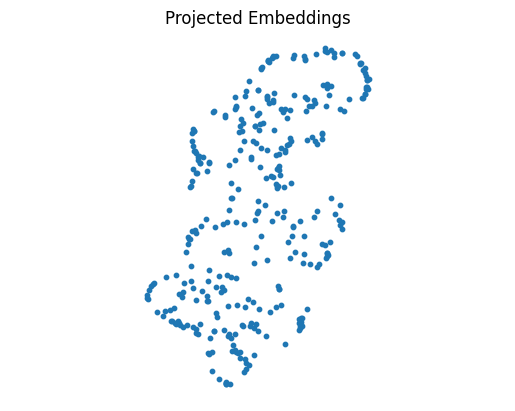

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')
plt.show()

## Relevancy and Distraction

RAG, or Retrieval Augmented Generation, is a strategy that helps address the limitations of LLMs by pairing information retrieval with carefully designed system prompts. It aims to provide LLMs with precise, up-to-date, and pertinent information from an external knowledge source, improving the accuracy and relevance of their responses.

Relevancy in RAG refers to the process of retrieving and providing relevant information to the LLM to answer a user's query. This involves using techniques such as vector embeddings to match the user's query with relevant information from databases, documents, or other sources. By doing so, the LLM can generate more accurate and contextually relevant responses.

On the other hand, distraction in the context of RAG refers to the challenge of dealing with irrelevant or unnecessary information within retrieved documents or chunks. This issue can impact token cost and response accuracy, as well as increase the likelihood of bumping into context-length limits. To address this, a critical step in most RAG pipelines is Relevance Extraction, where the LLM extracts only the portions of the text that are directly relevant to the query. This helps to reduce the amount of text that needs to be processed and improves the efficiency and accuracy of the system.

In [8]:
query = "What is the total revenue?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

revenue, classified by significant product and service offerings, was
as follows : ( in millions ) year ended june 30, 2022 2021 2020 server
products and cloud services $ 67, 321 $ 52, 589 $ 41, 379 office
products and cloud services 44, 862 39, 872 35, 316 windows 24, 761 22,
488 21, 510 gaming 16, 230 15, 370 11, 575 linkedin 13, 816 10, 289 8,
077 search and news advertising 11, 591 9, 267 8, 524 enterprise
services 7, 407 6, 943 6, 409 devices 6, 991 6, 791 6, 457 other 5, 291
4, 479 3, 768 total $ 198, 270 $ 168, 088 $ 143, 015 we have recast
certain previously reported amounts in the table above to conform to
the way we internally manage and monitor our business.

74 note 13 — unearned revenue unearned revenue by segment was as
follows : ( in millions ) june 30, 2022 2021 productivity and business
processes $ 24, 558 $ 22, 120 intelligent cloud 19, 371 17, 710 more
personal computing 4, 479 4, 311 total $ 48, 408 $ 44, 141 changes in
unearned revenue were as follows : ( in millio

Some of the retrieved fragments seems not directly related to the query.

In [11]:
# compute the query embedding using the embedding function
query_embedding = embedding_function([query])[0]

# priviously results retrieved embeddings
results_retrieved_embeddings = results['embeddings'][0]

# project the query and retrieved embeddings
projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(results_retrieved_embeddings, umap_transform)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  4.45it/s]


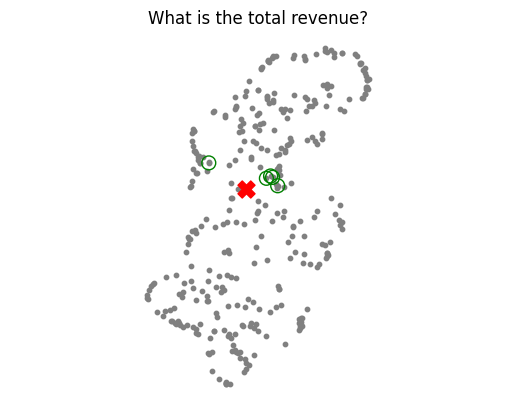

In [13]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')
plt.show()

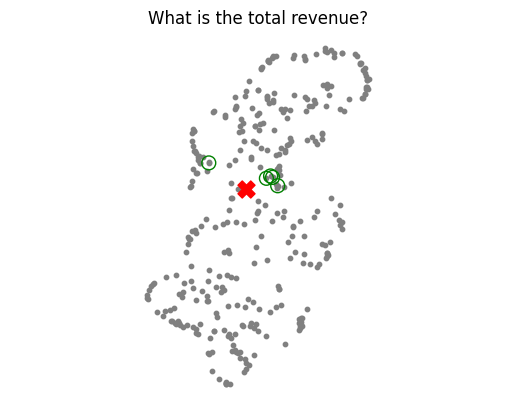

In [14]:
# design the plotting function

def plot_embeddings(projected_dataset_embeddings, projected_query_embedding, projected_retrieved_embeddings, query):
    """
    Plots the dataset embeddings, query embedding, and retrieved embeddings in a 2D space.
    
    Parameters:
    projected_dataset_embeddings (np.ndarray): 2D array with dataset embeddings projected in 2D.
    projected_query_embedding (np.ndarray): 2D array with the query embedding projected in 2D.
    projected_retrieved_embeddings (np.ndarray): 2D array with retrieved embeddings projected in 2D.
    query (str): The query title to be used in the plot.
    """
    plt.figure()
    plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
    plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
    plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{query}')
    plt.axis('off')
    plt.show()

plot_embeddings(projected_dataset_embeddings, projected_query_embedding, projected_retrieved_embeddings, query)

In [15]:
query = "What is the strategy around artificial intelligence (AI) ?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

culture of trust can help navigate the challenges the world faces
today. organizations of all sizes have digitized business - critical
functions, redefining what they can expect from their business
applications. customers are looking to unlock value while simplifying
security and management. from infrastructure and data, to business
applications and collaboration, we provide unique, differentiated value
to customers. we are building a distributed computing fabric – across
cloud and the edge – to help every organization build, run, and manage
mission - critical workloads anywhere. in the next phase of innovation,
artificial intelligence ( “ ai ” ) capabilities are rapidly advancing,
fueled by data and knowledge of the world. we are enabling metaverse
experiences at all layers of our stack, so customers can more
effectively model, automate, simulate, and predict changes within their
industrial

every organization turn its data into predictive and analytical power.
with our new microsoft 

In [16]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:01<00:00,  4.49it/s]


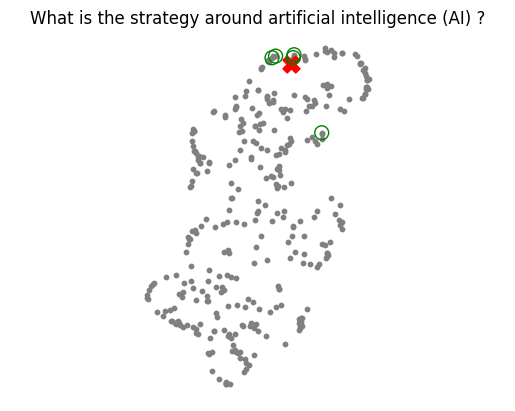

In [17]:
# Plot the projected query and retrieved documents in the embedding space
plot_embeddings(projected_dataset_embeddings, projected_query_embedding, projected_retrieved_embeddings, query)

In [18]:
query = "What has been the investment in research and development?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

• operating expenses increased $ 1. 5 billion or 14 % driven by
investments in gaming, search and news advertising, and windows
marketing. operating expenses research and development ( in millions,
except percentages ) 2022 2021 percentage change research and
development $ 24, 512 $ 20, 716 18 % as a percent of revenue 12 % 12 %
0ppt research and development expenses include payroll, employee
benefits, stock - based compensation expense, and other headcount -
related expenses associated with product development. research and
development expenses also include third - party development and
programming costs, localization costs incurred to translate software
for international markets, and the amortization of purchased software
code and services content. research and development expenses increased
$ 3. 8 billion or 18 % driven by investments in cloud engineering,
gaming, and linkedin. sales and marketing

competitive in local markets and enables us to continue to attract top
talent from ac

In [19]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:01<00:00,  3.96it/s]


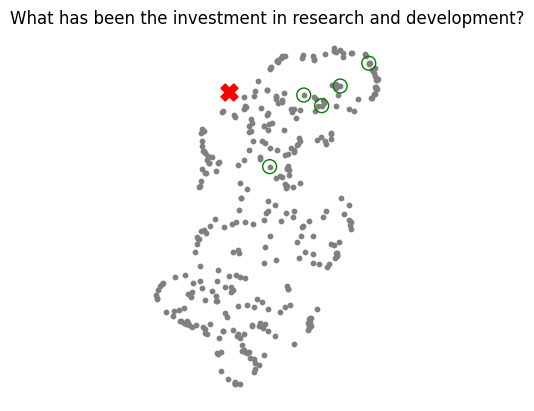

In [20]:
# Plot the projected query and retrieved documents in the embedding space
plot_embeddings(projected_dataset_embeddings, projected_query_embedding, projected_retrieved_embeddings, query)

In [21]:
query = "What has Michael Jordan done for us lately?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

we use metrics in assessing the performance of our business and to make
informed decisions regarding the allocation of resources. we disclose
metrics to enable investors to evaluate progress against our ambitions,
provide transparency into performance trends, and reflect the continued
evolution of our products and services. our commercial and other
business metrics are fundamentally connected based on how customers use
our products and

our success is based on our ability to create new and compelling
products, services, and experiences for our users, to initiate and
embrace disruptive technology trends, to enter new geographic and
product markets, and to drive broad adoption of our products and
services. we invest in a range of emerging technology trends and
breakthroughs that we believe offer significant opportunities to
deliver value to our customers and growth for the company. based on our
assessment of key technology trends, we maintain our long - term
commitment to research and de

In [22]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:01<00:00,  4.00it/s]


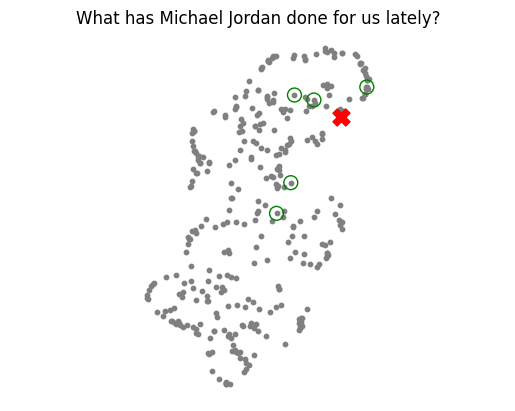

In [23]:
# Plot the projected query and retrieved documents in the embedding space
plot_embeddings(projected_dataset_embeddings, projected_query_embedding, projected_retrieved_embeddings, query)